# Preprocessing Sandwich and Dome Data

In [4]:
%matplotlib inline

import os
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as ssp
import matplotlib.pyplot as plt

<div class="alert alert-info">
   
# Navigating this notebook
*** ***  
**Input/Output & Parameters**
0. [Directories and Defining parameters](#step0)
1. [Load data and make output folders](#load_data)
    <br>
    <br>
    
**Filtering: mitochondrial, ribosomal, ncRNA gene high cells**
2. [Filtering cells based on mitochondrial gene expression](#mito_filter)
3. [Filtering cells based on ribosomal genes](#ribo_filter)
4. [Summary of # barcodes (cells) pre-filter and post-filter](#bc_summary)
    <br>
    <br>

**Preprocessing for visualization**
5. [Preprocessing: normalization, logarithmizing, choosing highly variable genes](#pp_norm_log_hvg) 
6. [Annotate cells for cell cycle scores](#cc_phases)
7. [Preprocessing: Z-score the log-transformed counts matrix, reduce dimensionality, batch correction, cluster, and visualize](#pp_z_score_log_pca_leiden_umap)
    <br>
    <br>
    
**Save files**
8. [UMAP plot - Figure S1C](#S1C)  
9. [Save h5ad file](#save_all) 
    
</div>  

<a id='step0'></a>

## Directories for input and output data

In [5]:
# for AnnData objects from Scanpy:
# These AnnData objects contain output from the filtering and QC notebook
# Containing unnormalized counts matrices with low-count barcodes removed
h5ad_dir = '_h5ad_files'
os.makedirs(h5ad_dir, exist_ok=True)

# for plots from matplotlib, seaborn, helper functions plots:
plot_dir = '_plots_preprocessing'
os.makedirs(plot_dir, exist_ok=True)

### Set up export formatting for scanpy figures

In [6]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                     frameon=True, vector_friendly=True, fontsize=14, 
                     figsize=None, color_map=None, format='eps', 
                     facecolor=None, transparent=False, ipython_format='png2x')

<a id='load_data'></a>

## Load/Save Count Data from/into h5ad files 

In [7]:
# To load the filtered files at a later point:
sample_list = ['Dome-R1-2.1', 'Dome-R1-2.2', 'Dome-R1-2.3', 'Dome-R1-2.4', 'Sand-R2-1.1']
D = {}
for s in sample_list:
    D[s] = sc.read(f'{h5ad_dir}/{s}-filtered.h5ad')
gene_list = D[s].var_names.values.astype(str)

In [8]:
# merge anndata objects into one object
adata = sc.AnnData.concatenate(
    *[D[s] for s in sample_list], 
    batch_key='Library Name',
    batch_categories=sample_list
)

In [9]:
def gene_list_lowercase(adata):
    adata_gene_lower = []
    for gene_name in adata.var_names:
        gene_name = gene_name.lower()
        adata_gene_lower.append(gene_name)
    adata.var_names = adata_gene_lower

In [10]:
# keep all genes lowercase
# keep in mind for loading lists of genes later on
gene_list_lowercase(adata)

In [11]:
# 13395 cells x 40931 genes
adata.X

<13395x40931 sparse matrix of type '<class 'numpy.float32'>'
	with 16985525 stored elements in Compressed Sparse Row format>

In [12]:
# use scanpy's quality control metrics and store in AnnData object for later reference
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [13]:
# write as an AnnData file to recover before preprocessing if you ever need it
sc.write(f'{h5ad_dir}/adata_merged_raw_sand_dome.h5ad', adata)

... storing 'condition' as categorical


*** ***

<a id='mito_filter'></a>

## Filtering cells based on mitochondrial gene expression

In [14]:
# define mitochondrial genes
mito_genes = adata.var_names.str.startswith(("mt-"))
print(sum(mito_genes))

37


In [15]:
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add % mitochondrial genes per cell to .obs DataFrame in AnnData object
adata.obs['percent_mito'] = np.sum(
    ssp.csc_matrix(adata[:, mito_genes].X), axis=1).A1 / np.sum(ssp.csc_matrix(adata.X), axis=1).A1

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = ssp.csc_matrix(adata.X).sum(axis=1).A1

#sense-check
print(len(adata.var_names[mito_genes]))

37


### Plot fraction of UMIs belonging to mitochondrial genes for cells in dataset

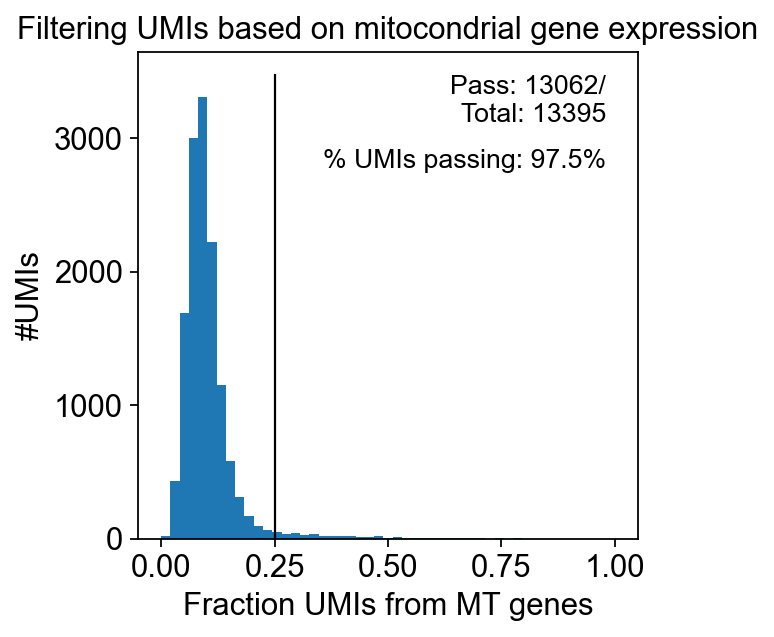

<Figure size 320x320 with 0 Axes>

In [16]:
# max fraction of UMIs coming from mitochondrial genes
max_mt = 0.25

adata.obs['mito_frac'] = adata.X[:,mito_genes].A.sum(1) / adata.obs['n_counts']
    
plt.hist(adata.obs['mito_frac'], np.linspace(0, 1, 50))

xl = np.array([0,1])
yl = np.array(plt.ylim())

plt.plot([max_mt,max_mt], yl, c='black', linewidth=1)
plt.grid(False)

ntot = len(adata.obs['mito_frac'])
npass = sum(adata.obs['mito_frac'] <= max_mt)


plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.9, 'Pass: {}/\n Total: {}'.format(npass, ntot), fontsize=12, ha='right')
plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.8, '% UMIs passing: {:.1f}%'.format(npass/ntot*100), fontsize=12, ha='right')

plt.title('Filtering UMIs based on mitocondrial gene expression')
plt.xlabel('Fraction UMIs from MT genes')
plt.ylabel('#UMIs')

plt.show()
plt.show()

plt.savefig(f'{plot_dir}/umis_passing_after_mito_{max_mt}_sand_dome.eps')

In [17]:
pct_mito = {}
for lib_name in adata.obs['Library Name'].unique():
    pct_mito[lib_name] = np.around(adata.obs.loc[adata.obs['Library Name'] == lib_name]['percent_mito'].mean()*100, 2)

<a id='ribo_filter'></a>

## Filtering cells based on ribosomal genes

In [18]:
# Also calculate percent malat1
ribo_genes = adata.var_names.str.startswith(("rps","rpl", "malat1"))
print(sum(ribo_genes))

adata.obs['percent_ribo'] = np.sum(
    ssp.csc_matrix(adata[:, ribo_genes].X), axis=1).A1 / np.sum(ssp.csc_matrix(adata.X), axis=1).A1

106


### Plot fraction of UMIs belonging to ribosomal genes for all cells

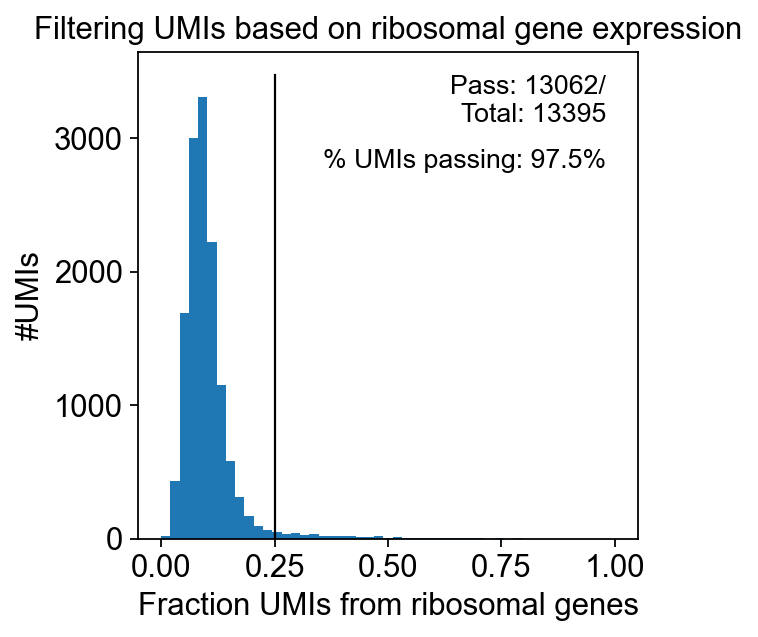

<Figure size 320x320 with 0 Axes>

In [19]:
# max fraction of UMIs coming from ribosomal genes
max_ribo = 0.25

adata.obs['ribo_frac'] = adata.X[:,mito_genes].A.sum(1) / adata.obs['n_counts']
    
plt.hist(adata.obs['ribo_frac'], np.linspace(0, 1, 50))

xl = np.array([0,1])
yl = np.array(plt.ylim())

plt.plot([max_ribo,max_ribo], yl, c='black', linewidth=1)
plt.grid(False)

ntot = len(adata.obs['ribo_frac'])
npass = sum(adata.obs['ribo_frac'] <= max_ribo)


plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.9, 'Pass: {}/\n Total: {}'.format(npass, ntot), fontsize=12, ha='right')
plt.text(xl[0] + xl.ptp()*0.98, yl[0] + yl.ptp() * 0.8, '% UMIs passing: {:.1f}%'.format(npass/ntot*100), fontsize=12, ha='right')

plt.title('Filtering UMIs based on ribosomal gene expression')
plt.xlabel('Fraction UMIs from ribosomal genes')
plt.ylabel('#UMIs')

plt.show()
plt.show()

plt.savefig(f'{plot_dir}/umis_passing_after_ribo_{max_ribo}_sand_dome.eps')

In [20]:
pct_ribo = {}
for lib_name in adata.obs['Library Name'].unique():
    pct_ribo[lib_name] = np.around(adata.obs.loc[adata.obs['Library Name'] == lib_name]['percent_ribo'].median()*100, 2)

### Plot metrics as violin plots for visualizing between conditions

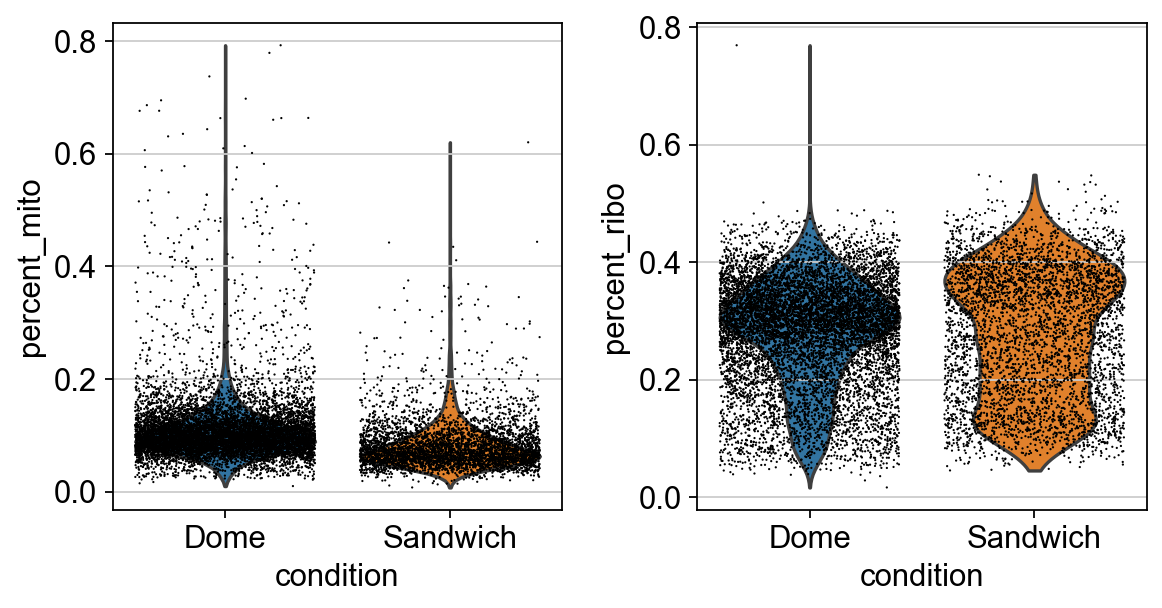

In [21]:
sc.pl.violin(adata, ['percent_mito','percent_ribo'],
             jitter=0.4, groupby = 'condition', save='_violin_plots_sandwich_dome')


### Visualize metrics with scatter plots for each library, instead of condition

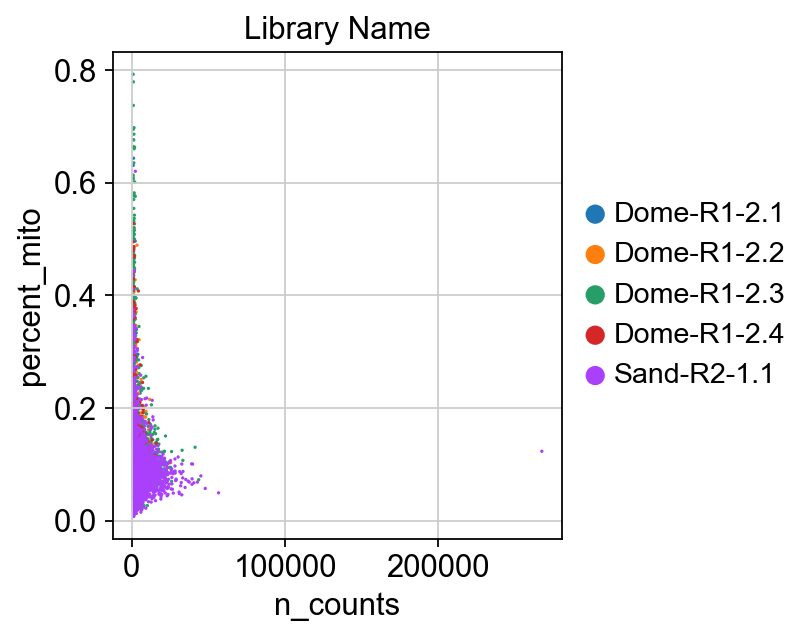

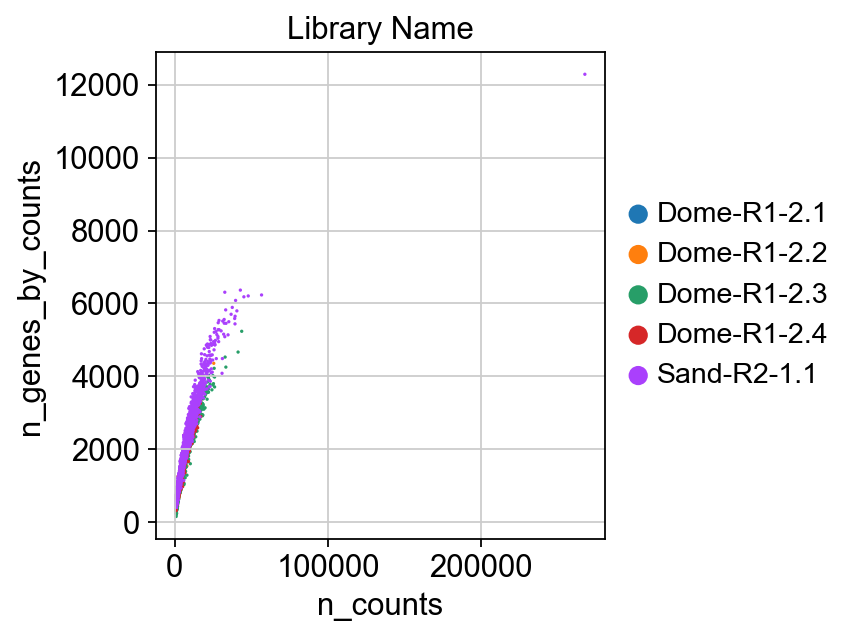

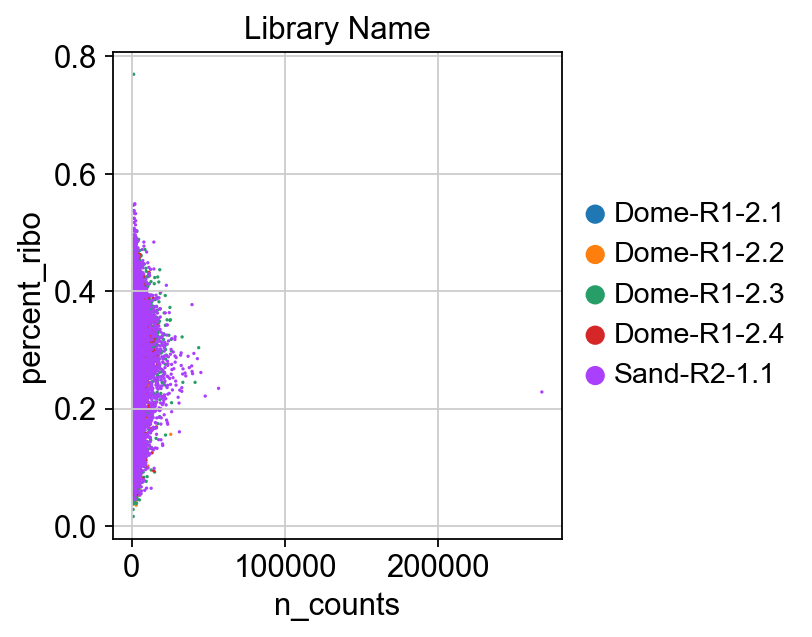

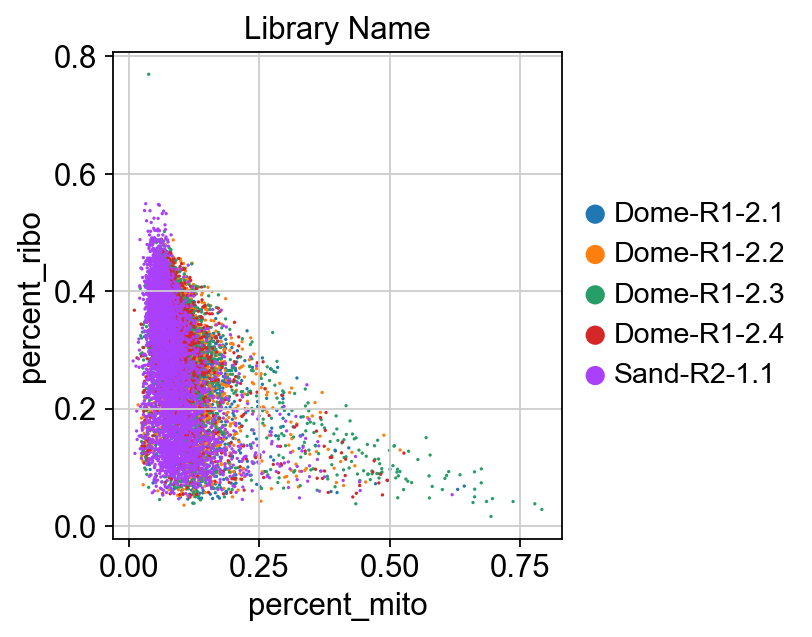

In [22]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito', color="Library Name", save='pct_mito_sand_dome')
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts', color="Library Name", save='genes_by_counts_sand_dome')

sc.pl.scatter(adata, x='n_counts', y='percent_ribo', color="Library Name", save='pct_ribo_sand_dome')
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo', color="Library Name", save='pct_ribo_v_pct_mito_sand_dome')

<a id='bc_summary'></a>

## Summary of # barcodes (cells) pre-filter and post-filter 

In [23]:
print('Sample\t\t\t# barcodes pre-filter\t\t# barcodes post-filter')

s = 'Merged'
n_orig = adata.shape[0]
adata = adata[adata.obs['mito_frac'] <= max_mt]
adata = adata[adata.obs['ribo_frac'] <= max_ribo]

# one more filtering step
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

n_pass = adata.shape[0]
print('{:20s}\t{}\t\t\t\t{}'.format(s, n_orig, n_pass))

Trying to set attribute `.obs` of view, copying.


Sample			# barcodes pre-filter		# barcodes post-filter
Merged              	13395				13062


In [24]:
# sense-check - manually inspect single gene to see results look reasonable
# numbers should be + !
adata.var[adata.var.index == 'lgr5'] 

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells
lgr5,1810,0.182158,0.167341,86.487495,2440.0,7.800163,1790


In [25]:
adata.raw = adata #save the filtered raw data, before normalizing

*** ***

<a id='pp_norm_log_hvg'></a>

## Preprocessing: Normalization, logarithmizing, choosing highly variable genes

In [26]:
# Total count normalize to CP10K - this overwrites X!
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) 

In [27]:
# sense check
print('before normalization:', adata.raw[1000].X.sum())
print('after normalization:', adata[1000].X.sum())

before normalization: 2675.0
after normalization: 9999.965


In [28]:
# log-transform the counts matrix
sc.pp.log1p(adata)

In [29]:
# calculate highly variable genes based on parameters below
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=8, min_disp=0.5)

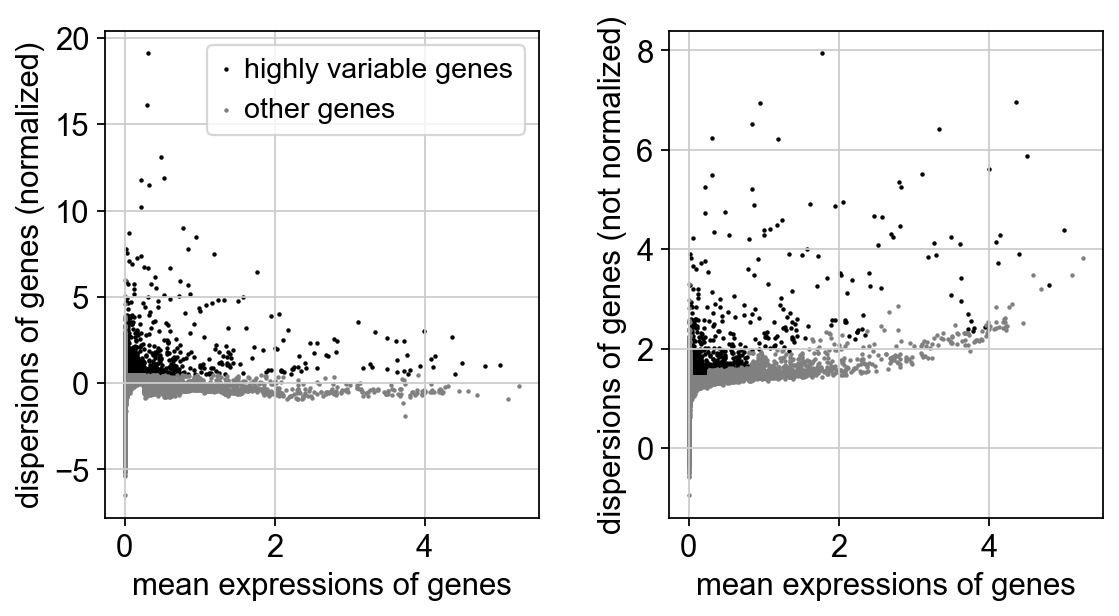

In [30]:
sc.pl.highly_variable_genes(adata)

In [31]:
# lgr5 and lyz1 should make it onto this list - let's double-check
print('lgr5 highly variable?:', adata.var[adata.var.index == 'lgr5']['highly_variable'].values)
print('lyz1 highly variable?:', adata.var[adata.var.index == 'lyz1']['highly_variable'].values)

lgr5 highly variable?: [ True]
lyz1 highly variable?: [ True]


<a id='cc_phases'></a>

## Annotate cells for cell cycle scores

#### Use cell cycle genes from [Tirosh and Izar et al., 2016](https://science.sciencemag.org/content/352/6282/189/tab-figures-data)

In [32]:
mouse_g2_m = pd.read_excel('cell_cycle_g2m.xlsx')

In [33]:
mouse_g1_s = pd.read_excel('cell_cycle_g1s.xlsx')

In [34]:
cc_g1s = []

for gene in list(mouse_g1_s['external_gene_name']): 
    if isinstance(gene, str) == True:
        if gene.lower() in adata.var_names:
            cc_g1s.append(gene.strip(' ').lower())

In [35]:
cc_g2m = []

for gene in list(mouse_g2_m['external_gene_name']): 
    if isinstance(gene, str) == True:
        if gene.lower() in adata.var_names:
            cc_g2m.append(gene.strip(' ').lower())

In [36]:
adata.var_names.unique()
sc.tl.score_genes_cell_cycle(adata, s_genes=cc_g1s, g2m_genes=cc_g2m)

In [37]:
cell_cycle_genes = [x for x in cc_g1s if x in adata.var_names] + [x for x in cc_g2m if x in adata.var_names]

... storing 'phase' as categorical


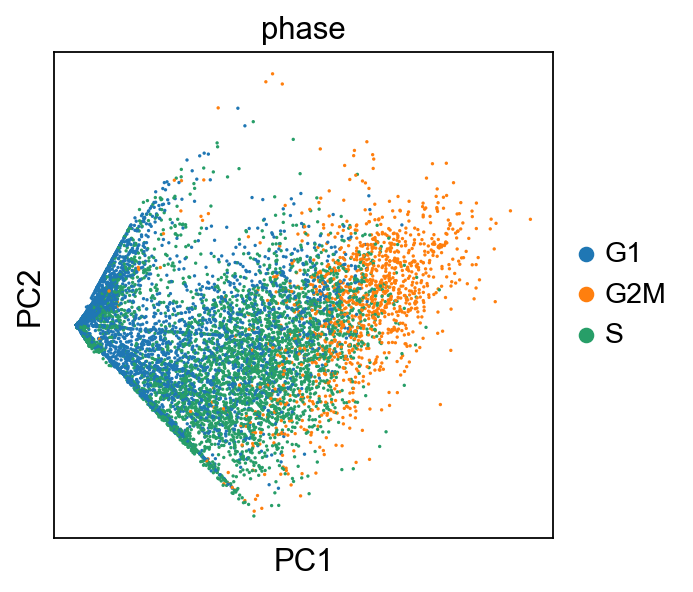

In [38]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

<a id='pp_z_score_log_pca_leiden_umap'></a>

## Preprocessing: Z-score the log-transformed counts matrix, reduce dimensionality, cluster, and visualize

In [39]:
# z-score before running PCA
sc.pp.scale(adata) 

### Dimensionality reduction: PCA

In [40]:
# run PCA
sc.pp.pca(adata, n_comps=15)

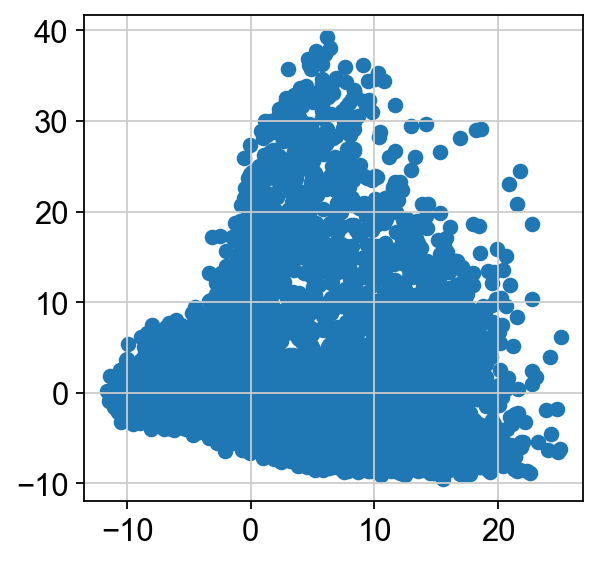

In [41]:
# plot the first two components as a sense-check
plt.scatter(x=adata.obsm['X_pca'][:, 0], y=adata.obsm['X_pca'][:, 1])

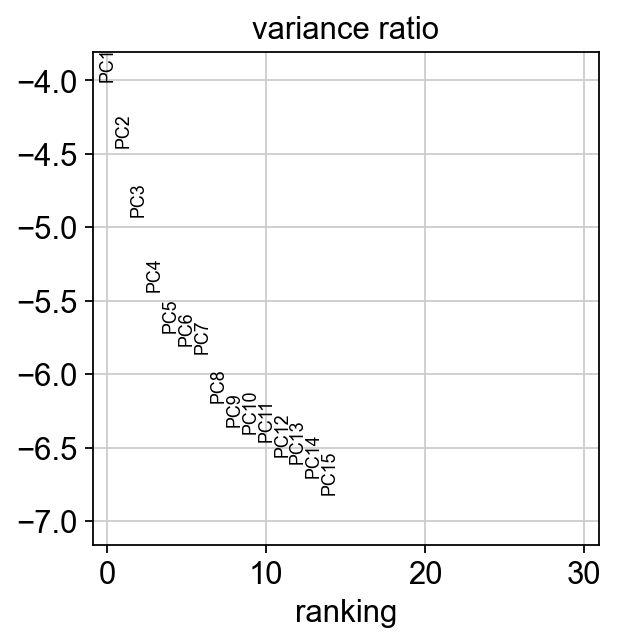

In [42]:
# use the elbow rule, iterating over different n_comps to choose # PCs
sc.pl.pca_variance_ratio(adata, log=True)

### Apply batch correction (BBKNN)

<div class="alert alert-info">
    
As described in: Polanski et al. (2019), BBKNN: fast batch alignment of single cell transcriptomes [Bioinformatics](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
    
</div>

In [43]:
batch_ids = []
for idx_ in adata.obs.index:
   #print(idx_.split('-')[1])
    batch_ids.append(idx_.split('-')[1])

In [44]:
adata.obs['batch'] = batch_ids

In [45]:
sc.external.pp.bbknn(adata)

### Leiden clustering

In [46]:
# setting number of neighbors will affect the the leiden clustering
sc.tl.leiden(adata, resolution=0.3, directed=False, n_iterations=-1)
# tune resolution so that you can clearly see a reasonable number of clusters for the timepoint
cluster_number = len(adata.obs['leiden'].cat.categories)
print(f'Number of clusters: {cluster_number}')

Number of clusters: 9


### Visualization with UMAP

In [47]:
sc.tl.umap(adata, random_state=111111) 

... storing 'batch' as categorical
... storing 'phase' as categorical


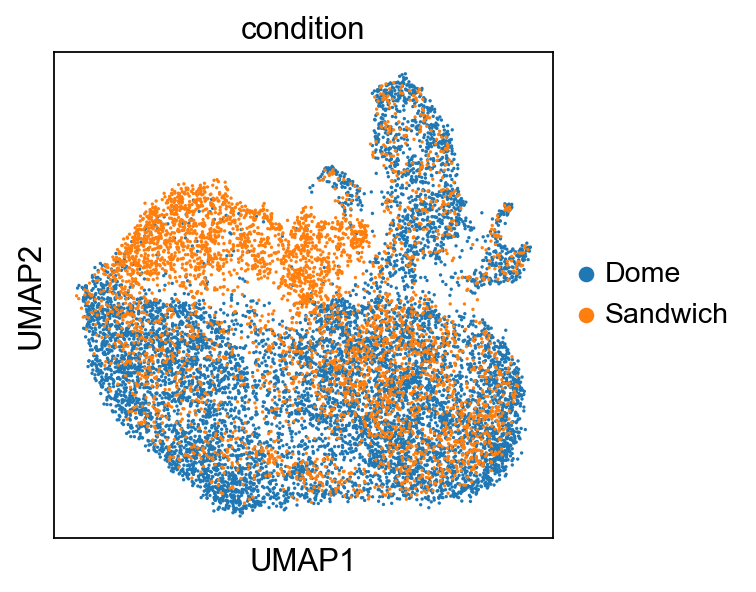

In [48]:
sc.pl.umap(adata, color='condition', save='_merged_pp_condition_sand_dome')

<a id='S1C'></a>

*** ***

## UMAP plot - Figure S1C

In [49]:
# Set up parameter settings for plots

# matplotlib params:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=12)
plt.rcParams['pdf.fonttype'] = 42

# scanpy settings:
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


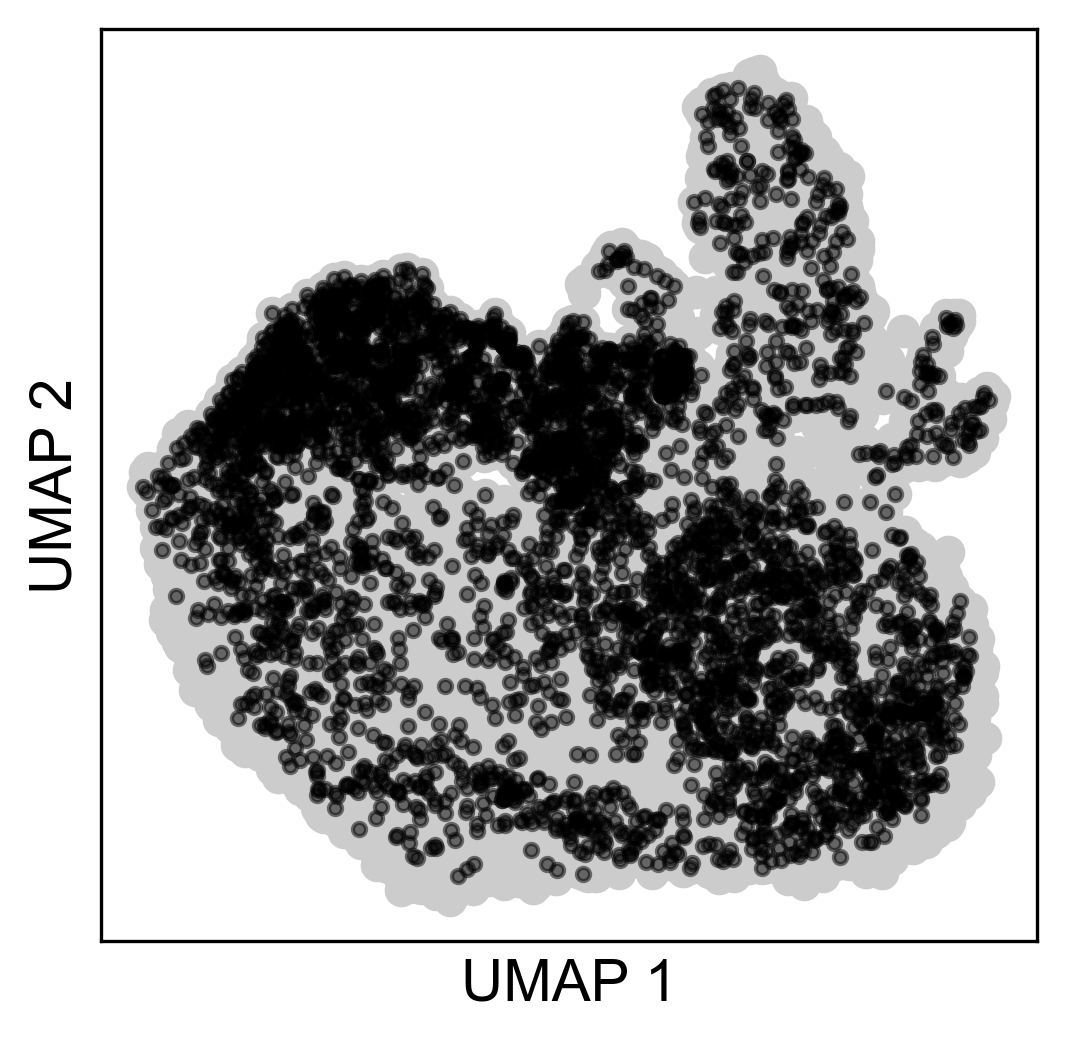

In [50]:
# making copies of xy coords and labels
umap_xy = adata.obsm['X_umap']
labels_umap = adata.obs['condition']
plt.grid(False)

plt.rcParams['figure.figsize'] = (5,5)

# this line hides x-labels and xticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# this line hides y-labels and yticks
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

plt.scatter(umap_xy[:, 0], umap_xy[:, 1], color=[0.8, 0.8, 0.8], s=50)
plt.scatter(umap_xy[labels_umap == 'Sandwich', 0], umap_xy[labels_umap == 'Sandwich', 1], color='k', alpha=0.5, s=10)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.savefig(f'{plot_dir}/sand_overlay_all.eps')

<a id='save_all'></a>

## Save h5ad file

In [51]:
sc.write(f'{h5ad_dir}/adata_pp_merged_batch_correct_sand_dome.h5ad', adata)

In [52]:
adata = sc.read(f'{h5ad_dir}/adata_pp_merged_batch_correct_sand_dome.h5ad')

#### Double check that the raw data is untouched

In [53]:
(adata.raw.X.sum(axis=1) > 1e4).sum()

1003

In [54]:
(adata.X.sum(axis=1) > 1e4).sum()

0